# ARIMA Model for Bitcoin price prediction

In this notebook I use ARIMA models with Walk-Forward-Validation to predict Bitcoin closing price the following day and, using that information, make decisions about buying or selling to to to beat the performance of a buy and hold strategy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime

The data is obtained from the following URL, using the download option in the web page:
https://finance.yahoo.com/quote/BTC-USD/history?period1=1451606400&period2=1632614400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [2]:
#We don't want warnings to repeat when we start using walk forward validation
import warnings
warnings.filterwarnings(action='once')

In [3]:
#we are loading the data from 01/01/2015 to 26/09/2021
btc_hist = pd.read_csv('./data_orig/BTC-USD.csv', index_col='Date')

/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#There are some missing values

btc_hist[btc_hist.isna().any(axis=1)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-09,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#We add the missing data manually (these values come from coinmarketcap.com)
#then we create a copy of the data so as not to change the original

btc_hist_m=btc_hist.copy()

btc_hist_m.loc['2020-10-13']=[11548.72, 11548.98, 11321.22,
        11425.90, 11425.90, 24241420251.0]
btc_hist_m.loc['2020-10-12']=[11392.64, 11698.47, 11240.69,
        11555.36, 11555.36, 26163972642.0]
btc_hist_m.loc['2020-10-09']=[10927.91, 11102.67, 10846.85,
        11064.46, 11064.46, 22799117613.0]
btc_hist_m.loc['2020-04-17']=[7116.55, 7167.18, 7050.33,
        7096.18, 7096.18, 32513423567.0]

btc_hist_m[btc_hist_m.isna().any(axis=1)]

/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [6]:
#We change the column Date to a date format
btc_hist_m.index=pd.to_datetime(arg=btc_hist_m.index,format='%Y-%m-%d')

/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
#Erasing unnecesary columns
btc_hist_m = btc_hist_m.drop(labels=['Open','High','Low','Adj Close'], axis=1)

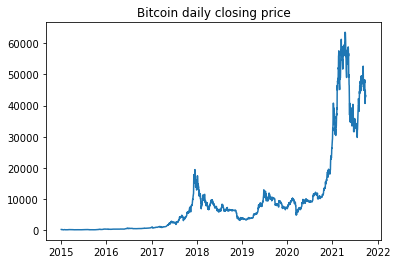

In [8]:
#Let's take a look at the data (closing price)
plt.plot(btc_hist_m.index, btc_hist_m['Close'])
plt.title("Bitcoin daily closing price")
plt.show()

/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


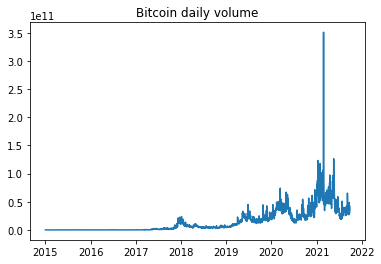

In [9]:
#Let's take a look at the data (volume)
plt.plot(btc_hist_m.index, btc_hist_m['Volume'])
plt.title("Bitcoin daily volume")
plt.show()

In [10]:
btc_hist_m_close = btc_hist_m.drop(labels=['Volume'], axis=1)
btc_hist_m_vol = btc_hist_m.drop(labels=['Close'], axis=1)

/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
#Decomposing into trend, seasonal and residue to try to understand the data better
final = seasonal_decompose(btc_hist_m_close,model='multiplicative')

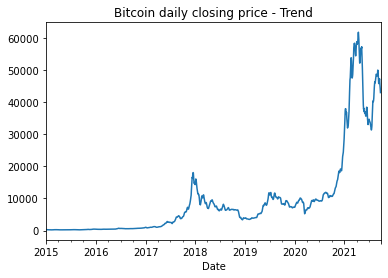

In [12]:
final.trend.plot()
plt.title("Bitcoin daily closing price - Trend")
plt.show()

/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


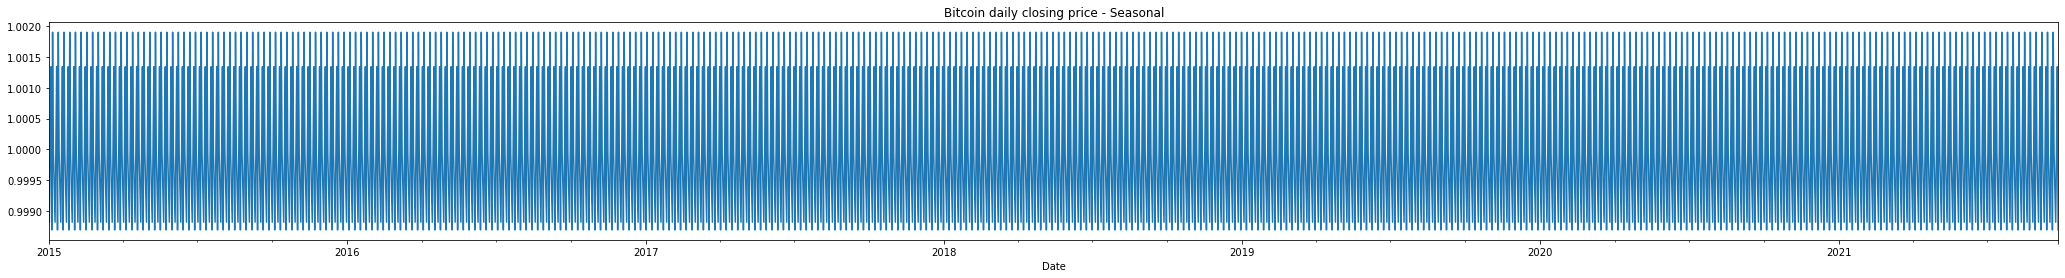

In [13]:
final.seasonal.plot(figsize=(36,4))
plt.title("Bitcoin daily closing price - Seasonal")
plt.show()

/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


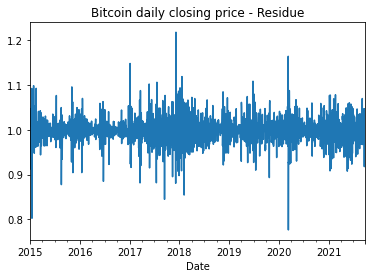

In [14]:
final.resid.plot()
plt.title("Bitcoin daily closing price - Residue")
plt.show()

/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


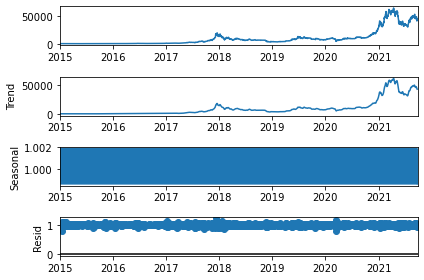

In [15]:
fig = final.plot()

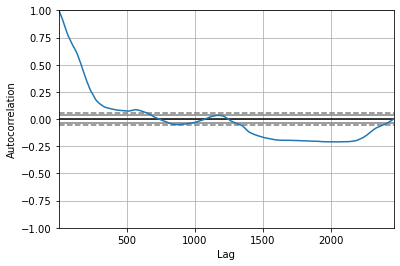

In [16]:
#We check the autocorrelation in the series and see
#that there is a significant positive autocorrelation with up to around 200 lags
autocorrelation_plot(btc_hist_m_close)
plt.show()

In [17]:
#We run the Augmented Dickey-Fuller test to check if the series is stationary
#The results indicate that the series is non-stationary
result = adfuller(btc_hist_m_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.554717
p-value: 0.880890


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


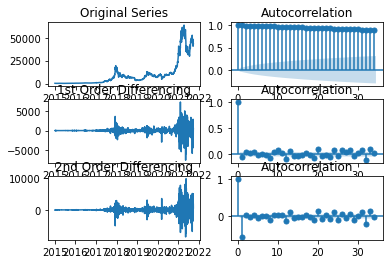

In [18]:
#Let's see what the original series and its fist and second differencing look like

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(btc_hist_m_close); axes[0, 0].set_title('Original Series')
plot_acf(btc_hist_m_close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(btc_hist_m_close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(btc_hist_m_close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(btc_hist_m_close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(btc_hist_m_close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [19]:
#We run the Augmented Dickey-Fuller test again to check if the 1st differencing series is stationary
#The results indicate that the 1st differencing series is stationary

result = adfuller(btc_hist_m_close.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.528008
p-value: 0.000000


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


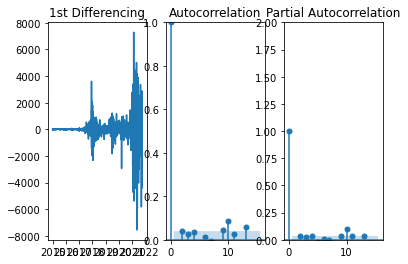

In [20]:
# PACF plot of 1st differenced series
# it shows that the autocorrelation is significant at 10 lags
# it also shows that the partial autocorrelation is significant at 10 lags
# According to this, the optimal values for p,d,q should be 10,1,10

fig, axes = plt.subplots(1, 3)
axes[0].plot(btc_hist_m_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1))
plot_acf(btc_hist_m_close.diff().dropna(), lags=15, ax=axes[1])
axes[2].set(ylim=(0,2))
plot_pacf(btc_hist_m_close.diff().dropna(), lags=15, ax=axes[2])

plt.show()

/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2461
Model:               ARIMA(10, 1, 10)   Log Likelihood              -19534.034
Date:                Thu, 03 Feb 2022   AIC                          39110.068
Time:                        08:24:02   BIC                          39232.035
Sample:                    01-01-2015   HQIC                         39154.384
                         - 09-26-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0122      0.205      0.059      0.953      -0.390       0.414
ar.L2         -0.0958      0.105     -0.916      0.360      -0.301       0.109
ar.L3         -0.2913      0.102     -2.852      0.0

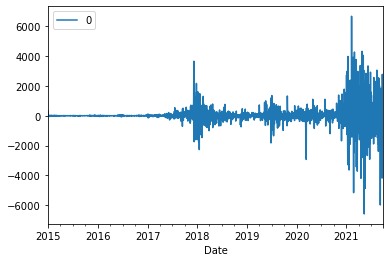

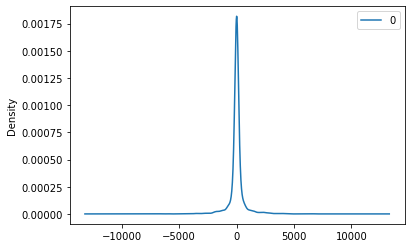

                 0
count  2461.000000
mean     15.691182
std     679.011814
min   -6588.468358
25%     -51.591559
50%       1.998645
75%      83.511971
max    6675.016664


In [21]:
# We fit the model and check residuals
model = ARIMA(btc_hist_m_close, order=(10,1,10))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [18]:
# We create Training, CV and Test sets to properly evaluate the models
no_test, test = train_test_split(btc_hist_m_close, shuffle=False, test_size=0.2)
train, cross_val = train_test_split(no_test, shuffle=False, test_size=0.2)


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


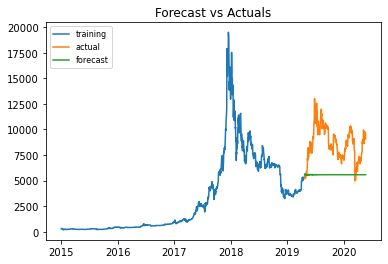

In [23]:
#Here we train the model with the train set and try to predict the cross validation set in one go
#As we can see in the plot, the results are terrible

# Build Model 
model = ARIMA(train, order=(10, 1, 10))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(490, alpha=0.05)  # 95% conf


# Turn into pandas series
fc_series = pd.Series(fc, index=cross_val.index)

# Plot
#plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(cross_val, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

bucle: 0.000000 predicted=5639.508813, expected=5464.866699, time:2022-02-03 08:24:11.449539
bucle: 1.000000 predicted=5398.394569, expected=5210.515625, time:2022-02-03 08:24:15.383921
bucle: 2.000000 predicted=5218.152737, expected=5279.348145, time:2022-02-03 08:24:19.392723
bucle: 3.000000 predicted=5293.693735, expected=5268.291016, time:2022-02-03 08:24:23.169756
bucle: 4.000000 predicted=5173.088800, expected=5285.139160, time:2022-02-03 08:24:26.898750
bucle: 5.000000 predicted=5273.553124, expected=5247.352539, time:2022-02-03 08:24:30.594083
bucle: 6.000000 predicted=5166.707927, expected=5350.726563, time:2022-02-03 08:24:34.475837
bucle: 7.000000 predicted=5363.430863, expected=5402.697266, time:2022-02-03 08:24:38.020581
bucle: 8.000000 predicted=5445.819223, expected=5505.283691, time:2022-02-03 08:24:41.785576
bucle: 9.000000 predicted=5523.264863, expected=5768.289551, time:2022-02-03 08:24:45.441496
bucle: 10.000000 predicted=5763.148239, expected=5831.167480, time:202

bucle: 87.000000 predicted=10592.048022, expected=10767.139648, time:2022-02-03 08:30:09.490162
bucle: 88.000000 predicted=10225.149013, expected=10599.105469, time:2022-02-03 08:30:13.305307
bucle: 89.000000 predicted=10691.599433, expected=10343.106445, time:2022-02-03 08:30:17.536979
bucle: 90.000000 predicted=10599.601516, expected=9900.767578, time:2022-02-03 08:30:21.417810
bucle: 91.000000 predicted=9754.238821, expected=9811.925781, time:2022-02-03 08:30:25.555298
bucle: 92.000000 predicted=10010.317085, expected=9911.841797, time:2022-02-03 08:30:29.484966
bucle: 93.000000 predicted=10284.173228, expected=9870.303711, time:2022-02-03 08:30:33.539697
bucle: 94.000000 predicted=9988.068222, expected=9477.677734, time:2022-02-03 08:30:37.489513
bucle: 95.000000 predicted=9805.423654, expected=9552.860352, time:2022-02-03 08:30:41.423096
bucle: 96.000000 predicted=9755.248329, expected=9519.145508, time:2022-02-03 08:30:45.435111
bucle: 97.000000 predicted=9091.320208, expected=96

bucle: 173.000000 predicted=8280.833974, expected=8374.686523, time:2022-02-03 08:36:24.399390
bucle: 174.000000 predicted=8315.316114, expected=8205.369141, time:2022-02-03 08:36:28.588345
bucle: 175.000000 predicted=8262.422113, expected=8047.526855, time:2022-02-03 08:36:32.958100
bucle: 176.000000 predicted=8232.593173, expected=8103.911133, time:2022-02-03 08:36:37.283155
bucle: 177.000000 predicted=8161.350030, expected=7973.207520, time:2022-02-03 08:36:41.476046
bucle: 178.000000 predicted=8143.465610, expected=7988.560547, time:2022-02-03 08:36:45.553055
bucle: 179.000000 predicted=7996.421605, expected=8222.078125, time:2022-02-03 08:36:49.758982
bucle: 180.000000 predicted=8252.058542, expected=8243.720703, time:2022-02-03 08:36:53.877457
bucle: 181.000000 predicted=8103.414712, expected=8078.203125, time:2022-02-03 08:37:01.567622
bucle: 182.000000 predicted=8009.889929, expected=7514.671875, time:2022-02-03 08:37:07.647993
bucle: 183.000000 predicted=7394.157941, expected=

bucle: 260.000000 predicted=8068.294451, expected=7879.071289, time:2022-02-03 08:42:50.831534
bucle: 261.000000 predicted=7936.927448, expected=8166.554199, time:2022-02-03 08:42:55.301755
bucle: 262.000000 predicted=8225.551515, expected=8037.537598, time:2022-02-03 08:42:59.624279
bucle: 263.000000 predicted=8018.553696, expected=8192.494141, time:2022-02-03 08:43:03.996560
bucle: 264.000000 predicted=8258.140624, expected=8144.194336, time:2022-02-03 08:43:08.788874
bucle: 265.000000 predicted=8055.689628, expected=8827.764648, time:2022-02-03 08:43:12.780452
bucle: 266.000000 predicted=8937.537269, expected=8807.010742, time:2022-02-03 08:43:17.145756
bucle: 267.000000 predicted=8719.957135, expected=8723.786133, time:2022-02-03 08:43:21.068462
bucle: 268.000000 predicted=8796.123328, expected=8929.038086, time:2022-02-03 08:43:25.499690
bucle: 269.000000 predicted=8838.891290, expected=8942.808594, time:2022-02-03 08:43:29.328509
bucle: 270.000000 predicted=8900.048198, expected=

bucle: 347.000000 predicted=6883.731323, expected=6791.129395, time:2022-02-03 08:48:38.621907
bucle: 348.000000 predicted=6733.546786, expected=7271.781250, time:2022-02-03 08:48:42.452051
bucle: 349.000000 predicted=7365.699625, expected=7176.414551, time:2022-02-03 08:48:46.545436
bucle: 350.000000 predicted=7212.743885, expected=7334.098633, time:2022-02-03 08:48:50.452465
bucle: 351.000000 predicted=7279.158531, expected=7302.089355, time:2022-02-03 08:48:54.356172
bucle: 352.000000 predicted=7319.759510, expected=6865.493164, time:2022-02-03 08:48:58.314918
bucle: 353.000000 predicted=6802.130995, expected=6859.083008, time:2022-02-03 08:49:02.399856
bucle: 354.000000 predicted=6852.572939, expected=6971.091797, time:2022-02-03 08:49:06.184082
bucle: 355.000000 predicted=6970.657566, expected=6845.037598, time:2022-02-03 08:49:10.171089
bucle: 356.000000 predicted=6785.394316, expected=6842.427734, time:2022-02-03 08:49:14.072788
bucle: 357.000000 predicted=6755.923101, expected=

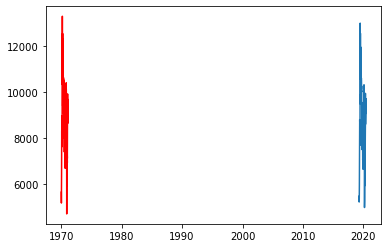

In [24]:
#Now we try to predict only one day ahead at a time (walk forward validation)

history = train
predictions = list()
# walk-forward validation
for t in range(len(cross_val)):
    model = ARIMA(history, order=(10,1,10), enforce_stationarity=False)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = cross_val.iloc[t]
    history=history.append(obs)
    print('bucle: %f predicted=%f, expected=%f, time:%s' % (t, yhat, obs, str(datetime.datetime.now())))
# evaluate forecasts
rmse = sqrt(mean_squared_error(cross_val, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(cross_val)
plt.plot(predictions, color='red')
plt.show()

/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


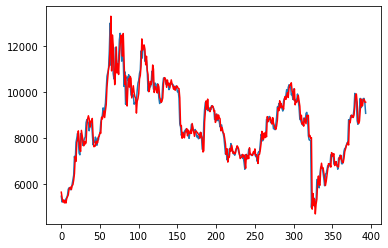

In [25]:
# The plot looks much better than when we where trying to predict everything in one go
# but, is it gooid enough at making predictions?
plt.plot(cross_val.reset_index().drop(labels=['Date'],axis=1))
plt.plot(predictions, color='red')
plt.show()

In [22]:
# Now we define a walk forward validation function.
# It doesn't just train the models and predict one day at a time,
# but it also simulates the decisions associated to those predictions,
# applying a 0.15% fee, and simulates the buy and hold strategy (naive model) for comparison.


def walk_forward_validation_arima (p_wfv, d_wfv, q_wfv, train_wfv, test_wfv):
    #This variables indicate wether, acording to the model and the logic, we would be invested or not
    invested2opt=True
    invested3opt=True
    
    #We are using 2 different logics.
    #In the first one (2opt), we only consider if the price will go up or down
    #In the second one (3opt), if our prediction is in the range -0.15% to 0.15% (0.15% is the price per transaction)
    #we don't change our invested/not-invested status, as the transaction price would cancel our profits
    transaction_price=0.0015
    result_naive=1
    result_mod_2opt=1
    result_mod_comis_2opt=1
    result_mod_3opt=1
    result_mod_comis_3opt=1
    
    predictions = list()
    for i in range(len(test_wfv)):
        model = ARIMA(train_wfv, order=(p_wfv,d_wfv,q_wfv), enforce_stationarity=False)
        
        model_fit = model.fit()
        output = model_fit.forecast()
        pred_wfv = output[0]
        predictions.append(pred_wfv)
        obs_prev=train_wfv.iloc[train_wfv.size-1].values
        obs = test_wfv.iloc[i]
        train_wfv=train_wfv.append(obs)
        
        
        if pred_wfv>=obs_prev:
            if not invested2opt:
                result_mod_comis_2opt=result_mod_comis_2opt*(1-transaction_price)
            invested2opt=True
        else:
            if invested2opt:
                result_mod_comis_2opt=result_mod_comis_2opt*(1-transaction_price)
            invested2opt=False
        
        if pred_wfv>obs_prev*(1+transaction_price):
            if not invested3opt:
                result_mod_comis_3opt=result_mod_comis_3opt*(1-transaction_price)
            invested3opt=True
        if pred_wfv<obs_prev*(1-transaction_price):
            if invested3opt:
                result_mod_comis_3opt=result_mod_comis_3opt*(1-transaction_price)
            invested3opt=False
        
        #naive model is always invested (or it always predicts the price will go up)
        result_naive=result_naive*(obs/obs_prev)
        #if the model is invested then we apply the price variation for the following day
        if invested2opt:
            result_mod_2opt=result_mod_2opt*(obs/obs_prev)
            result_mod_comis_2opt=result_mod_comis_2opt*(obs/obs_prev)
        
        if invested3opt:
            result_mod_3opt=result_mod_3opt*(obs/obs_prev)
            result_mod_comis_3opt=result_mod_comis_3opt*(obs/obs_prev)
    
    rmse = sqrt(mean_squared_error(test_wfv, predictions))
    
    return rmse, result_naive, result_mod_2opt, result_mod_comis_2opt, result_mod_3opt, result_mod_comis_3opt

# WARNING!!!! In my machine the next cell takes around 10 HOURS to run

In [28]:
# In this cell we variate the supposed "optimal" parameters to check if the model gets better

# The results of all the models and logics are notably worse than the naive model
# The result_naive variable (1.629787) indicates a 63% appreciation of the investment
# The best result taking fees into account (result_mod_comis_2opt and result_mod_comis_3opt variables)
# results in losses amounting to 5%

#Therefore, we consider the ARIMA models to not be good enough and decide to work on classification models

p_list=[9,10,11]
d_list=[0,1]
q_list=[9,10,11]

for p in p_list:
    for d in d_list:
        for q in q_list:
            print(str(datetime.datetime.now()))
            train_wfv=train.copy()
            cross_val_wfv=cross_val.copy()
            rmse, result_naive, result_mod_2opt, result_mod_comis_2opt, result_mod_3opt, result_mod_comis_3opt = \
                walk_forward_validation_arima(p, d, q, train_wfv, cross_val_wfv)
            print('Model p,d,q='+str(p)+','+str(d)+','+str(q))
            print('rmse='+str(rmse))
            print('Naive model result: '+str(result_naive))
            print('Current model result with 2-options decision: '+str(result_mod_comis_2opt))
            print('Current model result with 3-options decision: '+str(result_mod_comis_3opt))

2022-02-03 08:59:18.930645


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=9,0,9
rmse=397.6810413694351
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.774389
dtype: float64
Current model result with 3-options decision: Close    0.825646
dtype: float64
2022-02-03 09:30:56.344189


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=9,0,10
rmse=401.263825840635
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.551198
dtype: float64
Current model result with 3-options decision: Close    0.607406
dtype: float64
2022-02-03 10:08:21.857064


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=9,0,11
rmse=403.74691015421996
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.790992
dtype: float64
Current model result with 3-options decision: Close    0.771459
dtype: float64
2022-02-03 10:45:01.172951


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=9,1,9
rmse=405.349548052284
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.403508
dtype: float64
Current model result with 3-options decision: Close    0.585879
dtype: float64
2022-02-03 11:08:06.720992


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model p,d,q=9,1,10
rmse=403.88388778958165
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.722376
dtype: float64
Current model result with 3-options decision: Close    0.804122
dtype: float64
2022-02-03 11:31:30.178375


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model p,d,q=9,1,11
rmse=404.12056069693654
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.505315
dtype: float64
Current model result with 3-options decision: Close    0.638698
dtype: float64
2022-02-03 11:59:14.577403


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=10,0,9
rmse=394.6227350491115
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.493424
dtype: float64
Current model result with 3-options decision: Close    0.454583
dtype: float64
2022-02-03 12:31:34.221622


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=10,0,10
rmse=396.11740580134506
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.615796
dtype: float64
Current model result with 3-options decision: Close    0.526533
dtype: float64
2022-02-03 13:11:39.988793


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model p,d,q=10,0,11
rmse=398.52818655195733
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.496995
dtype: float64
Current model result with 3-options decision: Close    0.489837
dtype: float64
2022-02-03 13:50:26.507254


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=10,1,9
rmse=400.6010860718641
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.758698
dtype: float64
Current model result with 3-options decision: Close    0.781264
dtype: float64
2022-02-03 14:13:16.443057


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=10,1,10
rmse=406.0588698521191
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.666183
dtype: float64
Current model result with 3-options decision: Close    0.718244
dtype: float64
2022-02-03 14:41:30.896256


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=10,1,11
rmse=404.7926747716232
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.802231
dtype: float64
Current model result with 3-options decision: Close    0.947554
dtype: float64
2022-02-03 15:14:36.136373


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=11,0,9
rmse=394.194874662645
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.581431
dtype: float64
Current model result with 3-options decision: Close    0.640848
dtype: float64
2022-02-03 15:57:15.258133


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=11,0,10
rmse=396.5815058815427
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.518935
dtype: float64
Current model result with 3-options decision: Close    0.448861
dtype: float64
2022-02-03 16:41:10.461047


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=11,0,11
rmse=394.0014225800466
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.559466
dtype: float64
Current model result with 3-options decision: Close    0.631736
dtype: float64
2022-02-03 17:23:10.755276


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=11,1,9
rmse=399.21724388423587
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.509986
dtype: float64
Current model result with 3-options decision: Close    0.462422
dtype: float64
2022-02-03 17:47:28.569981


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model p,d,q=11,1,10
rmse=407.0223652776635
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.57045
dtype: float64
Current model result with 3-options decision: Close    0.834734
dtype: float64
2022-02-03 18:17:14.740189


/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dsc/anaconda3/envs/Crypto_Predictor/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model p,d,q=11,1,11
rmse=404.5307322840912
Naive model result: Close    1.629787
dtype: float64
Current model result with 2-options decision: Close    0.63726
dtype: float64
Current model result with 3-options decision: Close    0.817556
dtype: float64
